In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

from arch import arch_model
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.stats.diagnostic import acorr_ljungbox

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

symbol = 'AAPL'
start_date = '2020-01-01'
end_date = '2023-01-01'

stock_data = yf.download(symbol, start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed


Rolling vs EWMA Volatility

In [2]:
# Calculate volatility using rolling windows and EWMA
window = 21 # for rolling calculation
span = 21 # for EWMA

# Calculate daily return for each consecutive day
stock_data['Daily Return'] = stock_data['Adj Close'].pct_change()

annual_scaler = 252**0.5
stock_data['Rolling Volatility'] = stock_data['Daily Return'].rolling(window=window).std() * annual_scaler
stock_data['EWMA Volatility'] = stock_data['Daily Return'].ewm(span=span, adjust=False).std() * annual_scaler

Split data into Train/Test set

In [3]:
# Split the data into training and test sets
split_point = int(len(stock_data) * 0.8)
train_data = stock_data[:split_point].copy()
test_data = stock_data[split_point:].copy()

# Preprocessing
train_returns = train_data['Daily Return'].dropna().replace([np.inf, -np.inf], np.nan).dropna()
test_returns = test_data['Daily Return'].dropna().replace([np.inf, -np.inf], np.nan).dropna()

GARCH/EGARCH

In [4]:
# Fit a GARCH(1,1) and EGARCH(1,1) model
returns = stock_data['Daily Return'].dropna()

#GARCH(1,1)
garch_model = arch_model(returns, vol='Garch', p=1, q=1, rescale='false')
garch_results = garch_model.fit(disp="off")

# EGARCH(1,1)
egarch_model = arch_model(returns, vol='EGarch', p=1, q=1, rescale='false')
egarch_results = egarch_model.fit(disp="off")

GARCH/EGARCH: Evaluate with MSE

In [5]:
# Forecast GARCH volatility (analytic method: use model's equation)
garch_forecast = garch_results.forecast(horizon=len(test_returns))
garch_forecast_volatility = np.sqrt(garch_forecast.variance.values[-1, :])

# Forecast EGARCH volatility (simulation method: use average of Monte Carlo simulations)
egarch_forecast = egarch_results.forecast(horizon=len(test_returns), method='simulation')
egarch_forecast_volatility = np.sqrt(egarch_forecast.variance.values[-1, :])

# Observed volatility (use rolling stdev)
actual_volatility = test_returns.rolling(window=21).std() * np.sqrt(252)
actual_volatility = actual_volatility.dropna()

# Align lengths
garch_forecast_volatility = garch_forecast_volatility[-len(actual_volatility):]
egarch_forecast_volatility = egarch_forecast_volatility[-len(actual_volatility):]

# Calculate MSE for GARCH
garch_mse = mean_squared_error(actual_volatility, garch_forecast_volatility)

# Calculate MSE for EGARCH
egarch_mse = mean_squared_error(actual_volatility, egarch_forecast_volatility)

print(f"GARCH(1,1) MSE: {garch_mse}")
print(f"EGARCH(1,1) MSE: {egarch_mse}")


GARCH(1,1) MSE: 0.1154951408757152
EGARCH(1,1) MSE: 0.1142348336847423


GARCH/EGARCH: AIC/BIC Values

In [6]:
# Extract AIC and BIC for GARCH
garch_aic, garch_bic = garch_results.aic, garch_results.bic

# Extract AIC and BIC for EGARCH
egarch_aic, egarch_bic = egarch_results.aic, egarch_results.bic

print(f"GARCH(1,1) AIC: {garch_aic}, BIC: {garch_bic}")
print(f"EGARCH(1,1) AIC: {egarch_aic}, BIC: {egarch_bic}")

GARCH(1,1) AIC: -3679.922197344592, BIC: -3661.415326347596
EGARCH(1,1) AIC: -3680.1854578936754, BIC: -3661.6785868966795


In [7]:
# Scale data
scaler = StandardScaler()
X_train = scaler.fit_transform(train_returns.values.reshape(-1, 1))
X_test = scaler.transform(test_returns.values.reshape(-1, 1))

LSTM

In [8]:
# Prepate LSTM input
time_step = 21
X_train_lstm = np.array([X_train[i:(i + time_step), 0] for i in range(len(X_train) - time_step - 1)])
y_train_lstm = X_train[time_step:len(X_train) - 1, 0]
X_test_lstm = np.array([X_test[i:(i + time_step), 0] for i in range(len(X_test) - time_step - 1)])
y_test_lstm = X_test[time_step:len(X_test) - 1, 0]

# Reshape for LSTM
X_train_lstm = X_train_lstm.reshape(X_train_lstm.shape[0], X_train_lstm.shape[1], 1)
X_test_lstm = X_test_lstm.reshape(X_test_lstm.shape[0], X_test_lstm.shape[1], 1)

# Train LSTM model
lstm_model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(time_step, 1)),
    Dropout(0.2),
    LSTM(units=50, return_sequences=False),
    Dropout(0.2),
    Dense(units=1)
])
lstm_model.compile(optimizer='adam', loss='mean_squared_error')
lstm_model.fit(X_train_lstm, y_train_lstm, epochs=10, batch_size=32, verbose=0)

# Forecast with LSTM
lstm_predictions = lstm_model.predict(X_test_lstm)
lstm_predictions = scaler.inverse_transform(lstm_predictions)

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


LSTM: Evaluate with MSE

In [9]:
# LSTM Predictions
lstm_predictions = lstm_model.predict(X_test_lstm)
lstm_predictions = scaler.inverse_transform(lstm_predictions)

# Since y_test_lstm is not scaled back after training, we must also inverse scale it
y_test_lstm_rescaled = scaler.inverse_transform(y_test_lstm.reshape(-1, 1))

# Calculate MSE for LSTM
mse_lstm = mean_squared_error(y_test_lstm_rescaled, lstm_predictions)
print(f'Mean Squared Error (LSTM): {mse_lstm}')

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Mean Squared Error (LSTM): 0.0004900829524094444


SVR

In [10]:
# Prepare data for SVR
stock_data['Lagged_Volatility'] = stock_data['Rolling Volatility'].shift(1)
stock_data.dropna(inplace=True)

X = stock_data[['Lagged_Volatility']]
y = stock_data['Rolling Volatility']

# Split and scale data for SVR
X_train_svr, X_test_svr, y_train_svr, y_test_svr = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)
scaler_svr = StandardScaler()
X_train_svr_scaled = scaler_svr.fit_transform(X_train_svr)
X_test_svr_scaled = scaler_svr.transform(X_test_svr)

# Train SVR model
svr_model = SVR(kernel='rbf', C=1e3, gamma=0.1)
svr_model.fit(X_train_svr_scaled, y_train_svr)
y_pred_svr = svr_model.predict(X_test_svr_scaled)

SVR: Evaluate with MSE

In [11]:
mse_svr = mean_squared_error(y_test_svr, y_pred_svr)
print(f'Mean Squared Error (SVR): {mse_svr}')

Mean Squared Error (SVR): 0.0020151965393528396


Plot observed vs predicted values for test data

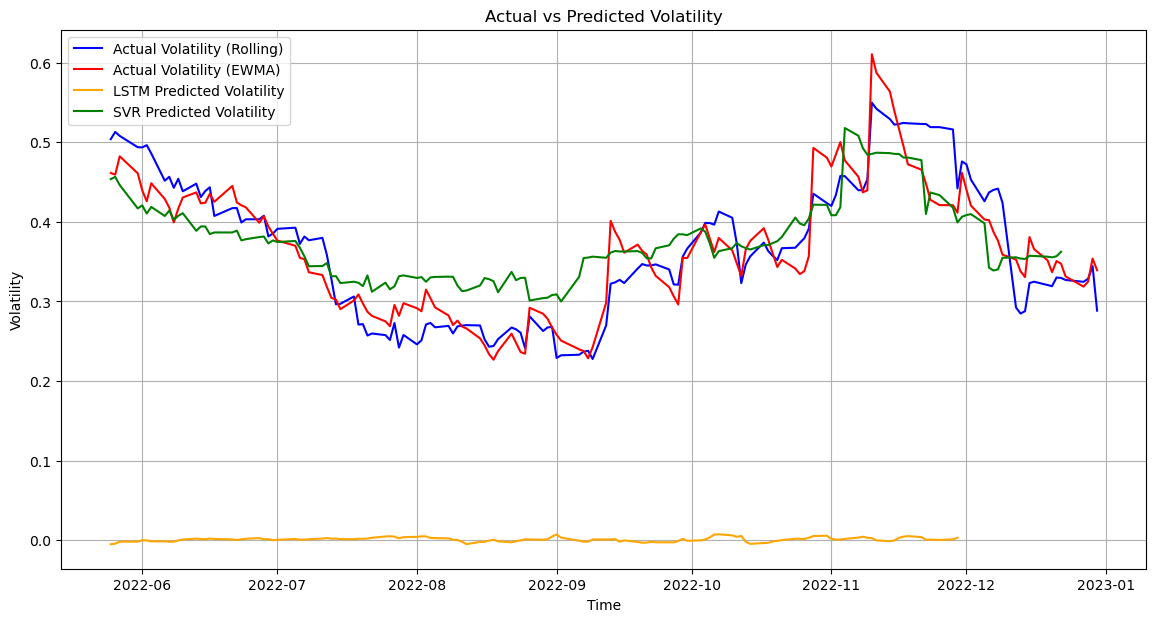

In [12]:
# Define the time period for the test data
time_period = test_data.index

# Plotting
plt.figure(figsize=(14, 7))

# Actual Volatility
plt.plot(time_period, test_data['Rolling Volatility'], label='Actual Volatility (Rolling)', color='blue')

plt.plot(time_period, test_data['EWMA Volatility'], label='Actual Volatility (EWMA)', color='red')

# LSTM Predicted Volatility
plt.plot(time_period[:len(lstm_predictions)], lstm_predictions, label='LSTM Predicted Volatility', color='orange')

# SVR Predicted Volatility
plt.plot(time_period[:len(y_pred_svr)], y_pred_svr, label='SVR Predicted Volatility', color='green')

# Add titles and labels
plt.title('Actual vs Predicted Volatility')
plt.xlabel('Time')
plt.ylabel('Volatility')
plt.legend()
plt.grid(True)
plt.show()
